In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance
import pickle
import time
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Load data

In [3]:
data = pd.read_pickle('../data/data_proton_photonsum_15_2133.pkl')
print('Loaded: ',  data.shape)
data_cond = pd.read_pickle('../data/data_cond_photonsum_15_2133_15_3273.pkl')
print('Loaded cond: ',  data_cond.shape)

Loaded:  (48714, 56, 30)
Loaded cond:  (48714, 12)


In [4]:
data_cond.drop(columns=['neutron_photon_sum', 'proton_photon_sum'], inplace=True)

In [5]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

data max 6.5206213 min 0.0
cond max 21.432093 min -35.632454


In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, data_cond, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(38971, 56, 30) (9743, 56, 30) (38971, 10) (9743, 10)


### Calculate channels for original simulation test data

In [7]:
from utils.utils import sum_channels_parallel
org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values 
del org

In [13]:
DATA_DIR = "12_03_2023_22_24/"

MODEL_FILEPATH = os.path.join("../models/", DATA_DIR, "gen_model_0.h5")

### Define functions for making histograms

In [16]:
def calculate_ws_ch(generator, n_calc, scale=1, noise_std=1):
    ws = [0, 0, 0, 0, 0]
    for j in range(n_calc):
        z = np.random.normal(0, noise_std, (x_test.shape[0], 10))
        z_c = y_test
        results = generator.predict([z, z_c])
        results = np.exp(results) - 1
        results = results * scale

        ch_gen = np.array(results).reshape(-1, 56, 30)
        ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
        for i in range(5):
          ws[i] = ws[i] + wasserstein_distance(ch_org[:, i], ch_gen[:, i])
        ws = np.array(ws)

    ws = ws / n_calc
    print("\n", "-" * 30, "\n")
    print("ws mean", f'{ws.sum() / 5:.2f}', end=" ")
    for n, score in enumerate(ws):
        print("ch" + str(n + 1), f'{score:.2f}', end=" ")


In [14]:
def make_histograms(NAME, model, scale=1, noise_std=1):
    generator = tf.keras.models.load_model(model)
    calculate_ws_ch(generator, 5, scale,  noise_std)

    z = np.random.normal(0,noise_std,(x_test.shape[0],10))
    z_c = y_test
    results = generator.predict([z,z_c])
    results = np.exp(results)-1
    results = results*scale

    ch_gen = np.array(results).reshape(-1,56,30)
    ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
    original=ch_org
    vae=ch_gen
    for i in range(5):
        bins = np.linspace(0, 1500, 250)
        plt.figure(figsize=(16,3))
        plt.yscale('log')
        plt.title(NAME+"\nKanał "+str(i+1))
        plt.hist(original[:,i], bins, alpha=0.5, label='true', color="red")
        plt.hist(vae[:,i], bins, alpha=0.5, label='generated', color="blue")
        plt.legend(loc='upper right')
        plt.ylabel('Liczba przykładów')
        plt.xlabel('Wartość kanału')
        plt.show()

### VAE

Proton data

305/305 [==============================] - 14s 45ms/step

 ------------------------------ 

305/305 [==============================] - 14s 46ms/step


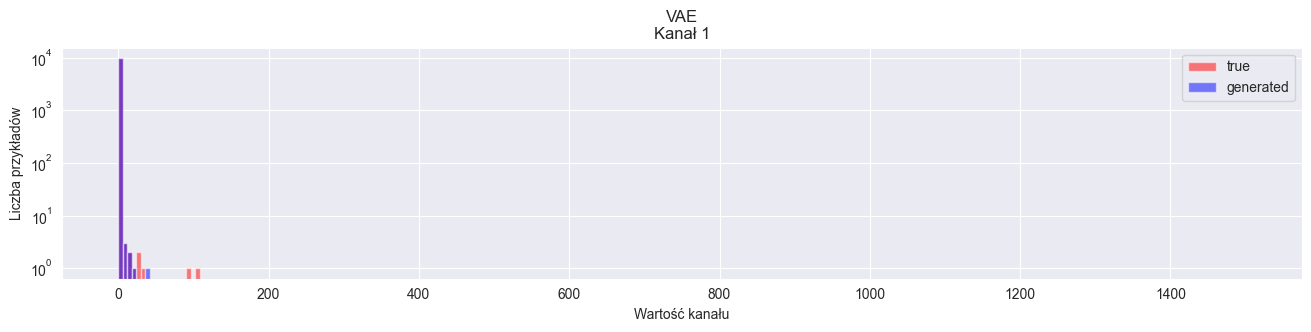

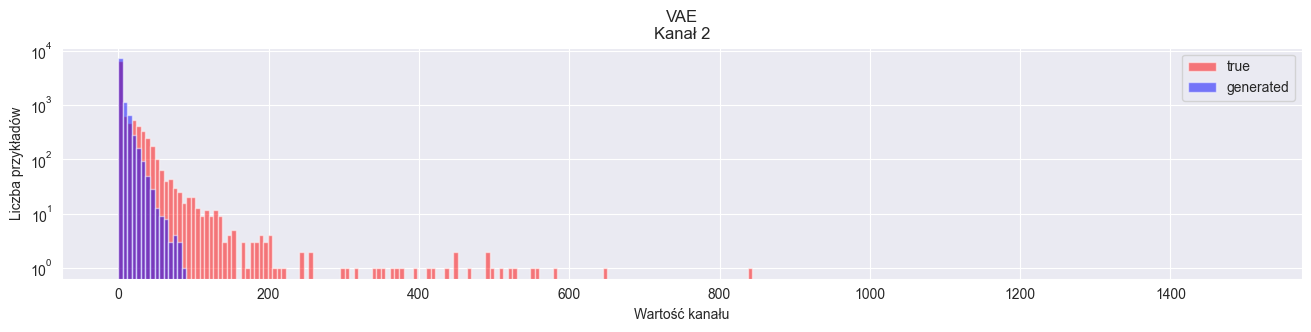

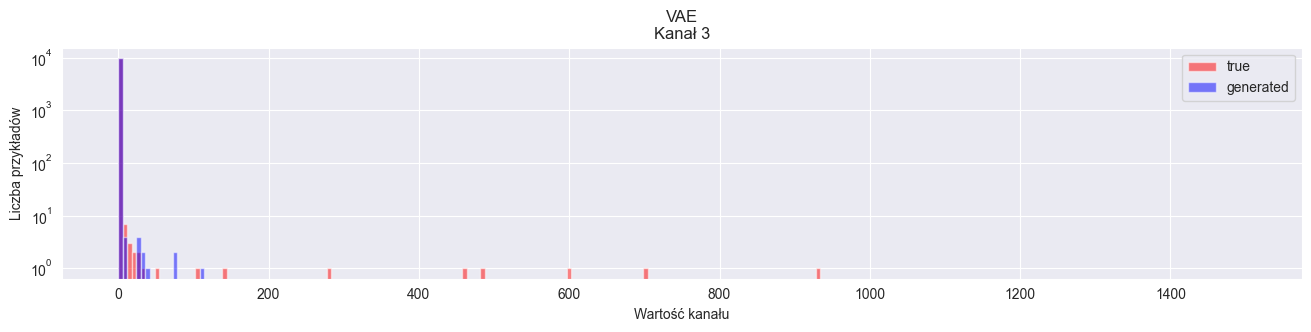

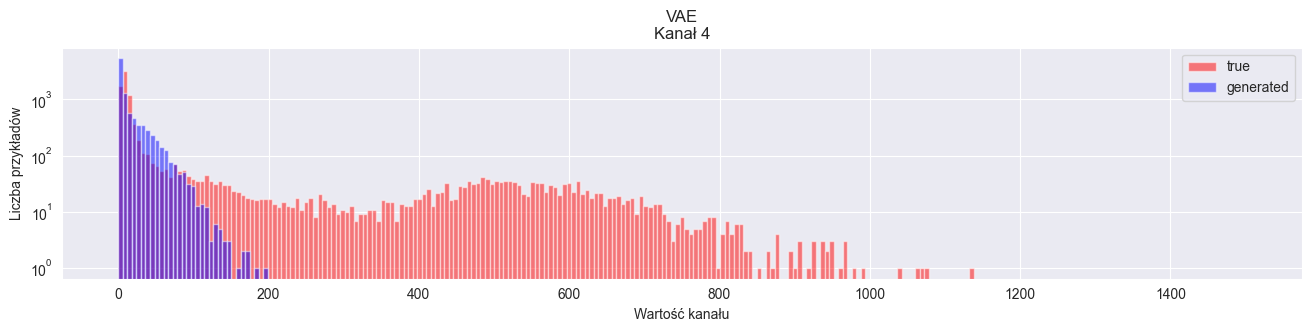

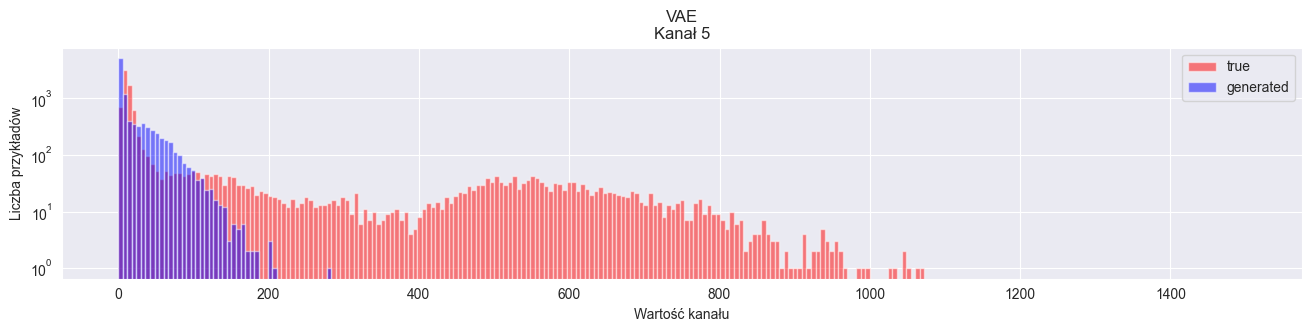

In [15]:
make_histograms("VAE",MODEL_FILEPATH,1,1)